## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.252423     584.398073   -21.601480     -26.402849   
1            2     -1.252423     584.398073   -21.601480     -26.402849   
2            3     -1.252423     584.398073   -21.601480     -26.402849   
3            4     -1.252423     584.398073   -21.601480     -26.402849   
4            5     -1.252423     584.398073   -21.601480     -26.402849   
...        ...           ...            ...          ...            ...   
1752345     46     -3.068643     528.790329   -15.910643     -20.374965   
1752346     47     -3.068643     528.790329   -15.910643     -20.374965   
1752347     48     -3.068643     528.790329   -15.910643     -20.374965   
1752348     49     -3.068643     528.790329   -15.910643     -20.374965   
1752349     50     -3.068643     528.790329   -15.910643     -20.374965   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)

        m1_pred = heat_diff_model(m1_input)

        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))


        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.005698655
RMSE of after m1 0.074766435
RMSE of after m3 0.07146638
RMSE of after m4 0.07422265
RMSE of after m0 0.0065959557
RMSE of after m1 0.051643554
RMSE of after m3 0.048849143
RMSE of after m4 0.050303623
RMSE of after m0 0.0054394505
RMSE of after m1 0.041548338
RMSE of after m3 0.04139186
RMSE of after m4 0.04170538
RMSE of after m0 0.004059918
RMSE of after m1 0.021278622
RMSE of after m3 0.021781744
RMSE of after m4 0.0370872
RMSE of after m0 0.003050807
RMSE of after m1 0.025225867
RMSE of after m3 0.026158875
RMSE of after m4 0.030061727
RMSE of after m0 0.002872178
RMSE of after m1 0.024985341
RMSE of after m3 0.026440801
RMSE of after m4 0.029745469
RMSE of after m0 0.0030956056
RMSE of after m1 0.024597123
RMSE of after m3 0.025567347
RMSE of after m4 0.028537165
RMSE of after m0 0.0030653607
RMSE of after m1 0.02498174
RMSE of after m3 0.02615465
RMSE of after m4 0.029044688
RMSE of after m0 0.0026081062
RMSE of after m1 0.018814992
RMSE of after m3 

RMSE of after m1 0.027182885
RMSE of after m3 0.027627671
RMSE of after m4 0.03501078
RMSE of after m0 0.0035486782
RMSE of after m1 0.01957811
RMSE of after m3 0.020283213
RMSE of after m4 0.030806933
RMSE of after m0 0.004024436
RMSE of after m1 0.018182486
RMSE of after m3 0.018722463
RMSE of after m4 0.029312884
RMSE of after m0 0.0051343506
RMSE of after m1 0.021498479
RMSE of after m3 0.02141828
RMSE of after m4 0.03964764
RMSE of after m0 0.005408303
RMSE of after m1 0.02323212
RMSE of after m3 0.023519246
RMSE of after m4 0.041935023
RMSE of after m0 0.0053222035
RMSE of after m1 0.022158954
RMSE of after m3 0.02281421
RMSE of after m4 0.03692471
RMSE of after m0 0.004726663
RMSE of after m1 0.023031116
RMSE of after m3 0.023106374
RMSE of after m4 0.035435524
RMSE of after m0 0.0045920047
RMSE of after m1 0.025436386
RMSE of after m3 0.026117489
RMSE of after m4 0.038762763
RMSE of after m0 0.0044937506
RMSE of after m1 0.022590451
RMSE of after m3 0.022668906
RMSE of after m4

RMSE of after m1 0.013109053
RMSE of after m3 0.023520734
RMSE of after m4 0.024358638
RMSE of after m0 0.0046746004
RMSE of after m1 0.014560351
RMSE of after m3 0.024725826
RMSE of after m4 0.025692493
RMSE of after m0 0.0052184486
RMSE of after m1 0.01577659
RMSE of after m3 0.023626834
RMSE of after m4 0.02465631
RMSE of after m0 0.004572036
RMSE of after m1 0.014941405
RMSE of after m3 0.024293797
RMSE of after m4 0.025628794
RMSE of after m0 0.0045008617
RMSE of after m1 0.029322326
RMSE of after m3 0.033048004
RMSE of after m4 0.03379791
RMSE of after m0 0.003518762
RMSE of after m1 0.014604939
RMSE of after m3 0.020295244
RMSE of after m4 0.020909721
RMSE of after m0 0.0039275647
RMSE of after m1 0.010431903
RMSE of after m3 0.013829681
RMSE of after m4 0.014677105
RMSE of after m0 0.00437096
RMSE of after m1 0.012569286
RMSE of after m3 0.02166338
RMSE of after m4 0.023511715
RMSE of after m0 0.005155025
RMSE of after m1 0.027052855
RMSE of after m3 0.025873931
RMSE of after m

RMSE of after m1 0.011598711
RMSE of after m3 0.027021049
RMSE of after m4 0.025604997
RMSE of after m0 0.0064533143
RMSE of after m1 0.034377135
RMSE of after m3 0.04230029
RMSE of after m4 0.040618848
RMSE of after m0 0.0062381094
RMSE of after m1 0.02141032
RMSE of after m3 0.035068452
RMSE of after m4 0.034123212
RMSE of after m0 0.0062500197
RMSE of after m1 0.015661327
RMSE of after m3 0.02993485
RMSE of after m4 0.028615564
RMSE of after m0 0.0062993504
RMSE of after m1 0.0129019385
RMSE of after m3 0.03079424
RMSE of after m4 0.029377455
RMSE of after m0 0.006463733
RMSE of after m1 0.010604001
RMSE of after m3 0.030888222
RMSE of after m4 0.02907058
RMSE of after m0 0.0058556073
RMSE of after m1 0.009765527
RMSE of after m3 0.027544102
RMSE of after m4 0.025909815
RMSE of after m0 0.0068995063
RMSE of after m1 0.012885607
RMSE of after m3 0.028508566
RMSE of after m4 0.02780608
RMSE of after m0 0.007250679
RMSE of after m1 0.011442482
RMSE of after m3 0.026423242
RMSE of after

RMSE of after m0 0.0036306942
RMSE of after m1 0.024591705
RMSE of after m3 0.029328613
RMSE of after m4 0.031541687
RMSE of after m0 0.0067768726
RMSE of after m1 0.02220277
RMSE of after m3 0.032904245
RMSE of after m4 0.03296004
RMSE of after m0 0.0038196577
RMSE of after m1 0.010586468
RMSE of after m3 0.028930558
RMSE of after m4 0.028988766
RMSE of after m0 0.0039744787
RMSE of after m1 0.022008015
RMSE of after m3 0.034443755
RMSE of after m4 0.035229616
RMSE of after m0 0.0039417567
RMSE of after m1 0.025243044
RMSE of after m3 0.029874219
RMSE of after m4 0.031734966
RMSE of after m0 0.0038974762
RMSE of after m1 0.018995656
RMSE of after m3 0.028236164
RMSE of after m4 0.029781155
RMSE of after m0 0.0041750357
RMSE of after m1 0.016735781
RMSE of after m3 0.026266212
RMSE of after m4 0.028209232
RMSE of after m0 0.0032223843
RMSE of after m1 0.017601075
RMSE of after m3 0.025123315
RMSE of after m4 0.0269787
RMSE of after m0 0.0044695903
RMSE of after m1 0.028194994
RMSE of a

RMSE of after m1 0.013653803
RMSE of after m3 0.010568419
RMSE of after m4 0.02009454
RMSE of after m0 0.008487068
RMSE of after m1 0.015616759
RMSE of after m3 0.01424765
RMSE of after m4 0.02489501
RMSE of after m0 0.0084365625
RMSE of after m1 0.0156824
RMSE of after m3 0.013760106
RMSE of after m4 0.025528619
RMSE of after m0 0.014098976
RMSE of after m1 0.06814138
RMSE of after m3 0.06607721
RMSE of after m4 0.069054455
RMSE of after m0 0.008926067
RMSE of after m1 0.04481332
RMSE of after m3 0.048756264
RMSE of after m4 0.049876846
RMSE of after m0 0.009396052
RMSE of after m1 0.12710512
RMSE of after m3 0.11951673
RMSE of after m4 0.12065369
RMSE of after m0 0.012959582
RMSE of after m1 0.12498609
RMSE of after m3 0.1254972
RMSE of after m4 0.12388527
RMSE of after m0 0.008612719
RMSE of after m1 0.14988907
RMSE of after m3 0.14753352
RMSE of after m4 0.1407407
RMSE of after m0 0.00701186
RMSE of after m1 0.052117214
RMSE of after m3 0.04817842
RMSE of after m4 0.056088597
RMSE 

RMSE of after m1 0.023471503
RMSE of after m3 0.025366776
RMSE of after m4 0.0539576
RMSE of after m0 0.0056137326
RMSE of after m1 0.026713645
RMSE of after m3 0.02764173
RMSE of after m4 0.05015807
RMSE of after m0 0.0048871236
RMSE of after m1 0.017062789
RMSE of after m3 0.018082863
RMSE of after m4 0.039570346
RMSE of after m0 0.0076497705
RMSE of after m1 0.031943243
RMSE of after m3 0.033075623
RMSE of after m4 0.068363264
RMSE of after m0 0.0065910295
RMSE of after m1 0.030143568
RMSE of after m3 0.031886354
RMSE of after m4 0.06658393
RMSE of after m0 0.0052389395
RMSE of after m1 0.0222685
RMSE of after m3 0.02422986
RMSE of after m4 0.053927235
RMSE of after m0 0.0078199105
RMSE of after m1 0.029382559
RMSE of after m3 0.03150189
RMSE of after m4 0.06741606
RMSE of after m0 0.008440293
RMSE of after m1 0.03465347
RMSE of after m3 0.035734594
RMSE of after m4 0.074302904
RMSE of after m0 0.005349224
RMSE of after m1 0.024791494
RMSE of after m3 0.02622879
RMSE of after m4 0.0

RMSE of after m0 0.010980566
RMSE of after m1 0.0398135
RMSE of after m3 0.038944848
RMSE of after m4 0.061976418
RMSE of after m0 0.008000717
RMSE of after m1 0.026570663
RMSE of after m3 0.026655372
RMSE of after m4 0.045479294
RMSE of after m0 0.007433379
RMSE of after m1 0.044202685
RMSE of after m3 0.044402607
RMSE of after m4 0.047435008
RMSE of after m0 0.006710851
RMSE of after m1 0.04201694
RMSE of after m3 0.03427494
RMSE of after m4 0.034761705
RMSE of after m0 0.010457798
RMSE of after m1 0.10646748
RMSE of after m3 0.103858985
RMSE of after m4 0.10411822
RMSE of after m0 0.0043563843
RMSE of after m1 0.03348404
RMSE of after m3 0.034268614
RMSE of after m4 0.03455679
RMSE of after m0 0.004084064
RMSE of after m1 0.023711279
RMSE of after m3 0.021211594
RMSE of after m4 0.023844434
RMSE of after m0 0.004334355
RMSE of after m1 0.012401352
RMSE of after m3 0.01519336
RMSE of after m4 0.01800393
RMSE of after m0 0.01046725
RMSE of after m1 0.3926342
RMSE of after m3 0.3900941

RMSE of after m1 0.032801174
RMSE of after m3 0.039537378
RMSE of after m4 0.04052872
RMSE of after m0 0.008217619
RMSE of after m1 0.047617324
RMSE of after m3 0.052260447
RMSE of after m4 0.05214024
RMSE of after m0 0.0047478387
RMSE of after m1 0.022794753
RMSE of after m3 0.030856162
RMSE of after m4 0.030974546
RMSE of after m0 0.0046046516
RMSE of after m1 0.017857052
RMSE of after m3 0.024430584
RMSE of after m4 0.024507912
RMSE of after m0 0.004363599
RMSE of after m1 0.011625157
RMSE of after m3 0.02417403
RMSE of after m4 0.023815667
RMSE of after m0 0.004946987
RMSE of after m1 0.015532619
RMSE of after m3 0.025539957
RMSE of after m4 0.02553394
RMSE of after m0 0.0046958635
RMSE of after m1 0.0090181995
RMSE of after m3 0.022806581
RMSE of after m4 0.023133487
RMSE of after m0 0.0049512577
RMSE of after m1 0.009520902
RMSE of after m3 0.023596583
RMSE of after m4 0.024659786
RMSE of after m0 0.0051678955
RMSE of after m1 0.0103643015
RMSE of after m3 0.0224116
RMSE of after

RMSE of after m1 0.011005191
RMSE of after m3 0.03439372
RMSE of after m4 0.033009432
RMSE of after m0 0.007744005
RMSE of after m1 0.014437635
RMSE of after m3 0.03626421
RMSE of after m4 0.034651835
RMSE of after m0 0.006840898
RMSE of after m1 0.010132759
RMSE of after m3 0.029385174
RMSE of after m4 0.028337264
RMSE of after m0 0.006079514
RMSE of after m1 0.009997578
RMSE of after m3 0.029553737
RMSE of after m4 0.028382177
RMSE of after m0 0.0065327813
RMSE of after m1 0.010127374
RMSE of after m3 0.026821265
RMSE of after m4 0.025649406
RMSE of after m0 0.006790831
RMSE of after m1 0.021773994
RMSE of after m3 0.03551611
RMSE of after m4 0.03373702
RMSE of after m0 0.006240908
RMSE of after m1 0.015936129
RMSE of after m3 0.031224357
RMSE of after m4 0.029304164
RMSE of after m0 0.0058405874
RMSE of after m1 0.017388232
RMSE of after m3 0.030573009
RMSE of after m4 0.02818294
RMSE of after m0 0.008071505
RMSE of after m1 0.025014585
RMSE of after m3 0.03766576
RMSE of after m4 0

RMSE of after m1 0.019568045
RMSE of after m3 0.034548078
RMSE of after m4 0.034953237
RMSE of after m0 0.009207372
RMSE of after m1 0.049401607
RMSE of after m3 0.05375996
RMSE of after m4 0.052390594
RMSE of after m0 0.011791195
RMSE of after m1 0.09349772
RMSE of after m3 0.09289578
RMSE of after m4 0.09377006
RMSE of after m0 0.0049186107
RMSE of after m1 0.046050392
RMSE of after m3 0.042409763
RMSE of after m4 0.044392135
RMSE of after m0 0.0039666826
RMSE of after m1 0.020050848
RMSE of after m3 0.023943963
RMSE of after m4 0.024670623
RMSE of after m0 0.0037207662
RMSE of after m1 0.011846481
RMSE of after m3 0.022250067
RMSE of after m4 0.022656662
RMSE of after m0 0.0037536998
RMSE of after m1 0.0096953
RMSE of after m3 0.019568224
RMSE of after m4 0.018631058
RMSE of after m0 0.0042269803
RMSE of after m1 0.009821295
RMSE of after m3 0.024664523
RMSE of after m4 0.023587385
RMSE of after m0 0.0047287843
RMSE of after m1 0.011632303
RMSE of after m3 0.03331101
RMSE of after m

RMSE of after m0 0.005711635
RMSE of after m1 0.020307928
RMSE of after m3 0.015585235
RMSE of after m4 0.03309962
RMSE of after m0 0.0054417704
RMSE of after m1 0.020178739
RMSE of after m3 0.015592487
RMSE of after m4 0.025218017
RMSE of after m0 0.005367448
RMSE of after m1 0.022405742
RMSE of after m3 0.017091723
RMSE of after m4 0.038538802
RMSE of after m0 0.005299498
RMSE of after m1 0.019131219
RMSE of after m3 0.014173229
RMSE of after m4 0.028011184
RMSE of after m0 0.0060951174
RMSE of after m1 0.025427973
RMSE of after m3 0.02056548
RMSE of after m4 0.04676216
RMSE of after m0 0.00635307
RMSE of after m1 0.02621075
RMSE of after m3 0.02037202
RMSE of after m4 0.05106223
RMSE of after m0 0.0058812504
RMSE of after m1 0.022030162
RMSE of after m3 0.016232336
RMSE of after m4 0.037293017
RMSE of after m0 0.006764855
RMSE of after m1 0.026873652
RMSE of after m3 0.022032684
RMSE of after m4 0.051679105
RMSE of after m0 0.0073839175
RMSE of after m1 0.03131647
RMSE of after m3 0

RMSE of after m1 0.014632829
RMSE of after m3 0.015465907
RMSE of after m4 0.037705302
RMSE of after m0 0.005293794
RMSE of after m1 0.016282963
RMSE of after m3 0.018305728
RMSE of after m4 0.026915228
RMSE of after m0 0.008684845
RMSE of after m1 0.024342772
RMSE of after m3 0.026113296
RMSE of after m4 0.061179724
RMSE of after m0 0.006515717
RMSE of after m1 0.026651112
RMSE of after m3 0.027376294
RMSE of after m4 0.066067405
RMSE of after m0 0.0060501476
RMSE of after m1 0.027065603
RMSE of after m3 0.02769229
RMSE of after m4 0.06505524
RMSE of after m0 0.007783389
RMSE of after m1 0.027726058
RMSE of after m3 0.028612487
RMSE of after m4 0.06243642
RMSE of after m0 0.005121411
RMSE of after m1 0.01792363
RMSE of after m3 0.019183083
RMSE of after m4 0.04063091
RMSE of after m0 0.008297481
RMSE of after m1 0.019121757
RMSE of after m3 0.020229021
RMSE of after m4 0.04238949
RMSE of after m0 0.0067393603
RMSE of after m1 0.018827034
RMSE of after m3 0.019524073
RMSE of after m4 0

RMSE of after m1 0.19515494
RMSE of after m3 0.1914546
RMSE of after m4 0.19492929
RMSE of after m0 0.0126123
RMSE of after m1 0.03653106
RMSE of after m3 0.039191395
RMSE of after m4 0.04024177
RMSE of after m0 0.010080055
RMSE of after m1 0.06465632
RMSE of after m3 0.0647289
RMSE of after m4 0.065016285
RMSE of after m0 0.004739465
RMSE of after m1 0.029263638
RMSE of after m3 0.027391734
RMSE of after m4 0.029791573
RMSE of after m0 0.0040014572
RMSE of after m1 0.014422588
RMSE of after m3 0.018107407
RMSE of after m4 0.020066814
RMSE of after m0 0.005117
RMSE of after m1 0.031955574
RMSE of after m3 0.02812111
RMSE of after m4 0.030202905
RMSE of after m0 0.004576986
RMSE of after m1 0.029606687
RMSE of after m3 0.03246063
RMSE of after m4 0.03493168
RMSE of after m0 0.0044046547
RMSE of after m1 0.04118293
RMSE of after m3 0.04405244
RMSE of after m4 0.045704357
RMSE of after m0 0.0060453736
RMSE of after m1 0.05210737
RMSE of after m3 0.046742838
RMSE of after m4 0.046527732
RM

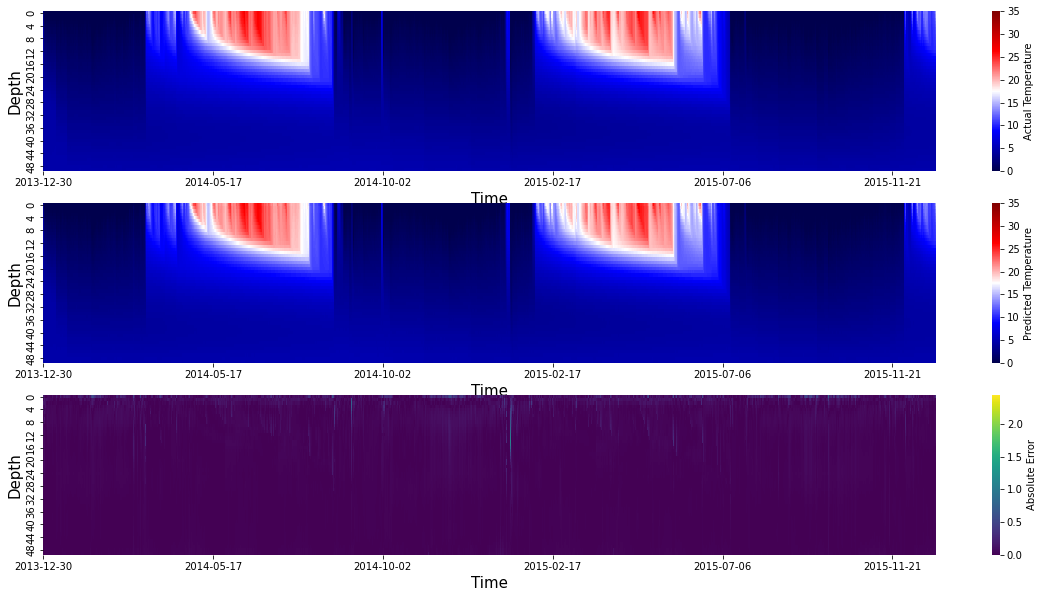

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

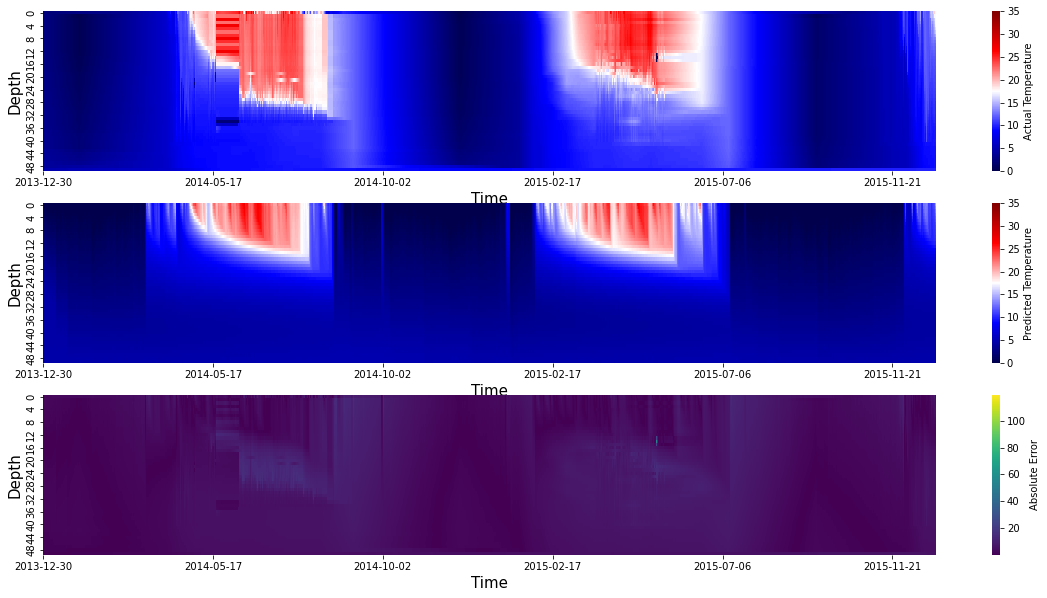

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.005462061
RMSE of after m1 0.011133773
RMSE of after m3 0.02007808
RMSE of after m4 0.020552346
RMSE of after m0 0.008037725
RMSE of after m1 0.05011545
RMSE of after m3 0.050846063
RMSE of after m4 0.050384067
RMSE of after m0 0.0050342428
RMSE of after m1 0.021993686
RMSE of after m3 0.030985653
RMSE of after m4 0.032026876
RMSE of after m0 0.004645544
RMSE of after m1 0.015777959
RMSE of after m3 0.024039123
RMSE of after m4 0.025172412
RMSE of after m0 0.0034410742
RMSE of after m1 0.018487949
RMSE of after m3 0.020211482
RMSE of after m4 0.021655638
RMSE of after m0 0.008830185
RMSE of after m1 0.01953411
RMSE of after m3 0.028101308
RMSE of after m4 0.029413307
RMSE of after m0 0.0040880223
RMSE of after m1 0.009766226
RMSE of after m3 0.020526333
RMSE of after m4 0.020261755
RMSE of after m0 0.004208882
RMSE of after m1 0.009541464
RMSE of after m3 0.022872945
RMSE of after m4 0.022626592
RMSE of after m0 0.004043874
RMSE of after m1 0.009889161
RMSE of after 

RMSE of after m1 0.01429177
RMSE of after m3 0.028922856
RMSE of after m4 0.026462557
RMSE of after m0 0.0058128713
RMSE of after m1 0.010566274
RMSE of after m3 0.025909033
RMSE of after m4 0.023482027
RMSE of after m0 0.0056511345
RMSE of after m1 0.008824499
RMSE of after m3 0.02538257
RMSE of after m4 0.023220096
RMSE of after m0 0.008584651
RMSE of after m1 0.035586677
RMSE of after m3 0.04795442
RMSE of after m4 0.04624032
RMSE of after m0 0.008123898
RMSE of after m1 0.026398528
RMSE of after m3 0.04378087
RMSE of after m4 0.042310104
RMSE of after m0 0.0064845183
RMSE of after m1 0.03286409
RMSE of after m3 0.041837018
RMSE of after m4 0.03917298
RMSE of after m0 0.006501628
RMSE of after m1 0.013147664
RMSE of after m3 0.0311775
RMSE of after m4 0.02907188
RMSE of after m0 0.005716874
RMSE of after m1 0.008851159
RMSE of after m3 0.02931007
RMSE of after m4 0.027335495
RMSE of after m0 0.0068111955
RMSE of after m1 0.02248022
RMSE of after m3 0.036027037
RMSE of after m4 0.033

RMSE of after m4 0.029408367
RMSE of after m0 0.00382975
RMSE of after m1 0.0168996
RMSE of after m3 0.024988675
RMSE of after m4 0.025924247
RMSE of after m0 0.005874915
RMSE of after m1 0.012162295
RMSE of after m3 0.03271154
RMSE of after m4 0.032845568
RMSE of after m0 0.0071454835
RMSE of after m1 0.013924964
RMSE of after m3 0.033231117
RMSE of after m4 0.03278046
RMSE of after m0 0.0059330408
RMSE of after m1 0.016138464
RMSE of after m3 0.029911986
RMSE of after m4 0.02832422
RMSE of after m0 0.006682483
RMSE of after m1 0.026932577
RMSE of after m3 0.0417725
RMSE of after m4 0.039059915
RMSE of after m0 0.004335117
RMSE of after m1 0.016413558
RMSE of after m3 0.025843825
RMSE of after m4 0.02453063
RMSE of after m0 0.006369516
RMSE of after m1 0.040009104
RMSE of after m3 0.044617686
RMSE of after m4 0.045111705
RMSE of after m0 0.004579877
RMSE of after m1 0.019844688
RMSE of after m3 0.02287172
RMSE of after m4 0.02440673
RMSE of after m0 0.004114919
RMSE of after m1 0.0114

RMSE of after m1 0.021426849
RMSE of after m3 0.018587647
RMSE of after m4 0.019471632
RMSE of after m0 0.005159009
RMSE of after m1 0.02108869
RMSE of after m3 0.019814793
RMSE of after m4 0.032432258
RMSE of after m0 0.004931334
RMSE of after m1 0.01989044
RMSE of after m3 0.015900875
RMSE of after m4 0.033377387
RMSE of after m0 0.0056160507
RMSE of after m1 0.029270424
RMSE of after m3 0.024788534
RMSE of after m4 0.039172888
RMSE of after m0 0.005347948
RMSE of after m1 0.01961985
RMSE of after m3 0.01825305
RMSE of after m4 0.037894752
RMSE of after m0 0.0071312906
RMSE of after m1 0.02837734
RMSE of after m3 0.024500791
RMSE of after m4 0.06614102
RMSE of after m0 0.005535313
RMSE of after m1 0.028624244
RMSE of after m3 0.023816869
RMSE of after m4 0.05238698
RMSE of after m0 0.0055301427
RMSE of after m1 0.022257676
RMSE of after m3 0.018676046
RMSE of after m4 0.046043586
RMSE of after m0 0.0051356643
RMSE of after m1 0.021092502
RMSE of after m3 0.019096969
RMSE of after m4 

RMSE of after m4 0.030241285
RMSE of after m0 0.0056260917
RMSE of after m1 0.017059995
RMSE of after m3 0.018197332
RMSE of after m4 0.027085034
RMSE of after m0 0.0057234704
RMSE of after m1 0.016911136
RMSE of after m3 0.01753344
RMSE of after m4 0.025169175
RMSE of after m0 0.0061867535
RMSE of after m1 0.0102148
RMSE of after m3 0.011407259
RMSE of after m4 0.023111494
RMSE of after m0 0.0064404863
RMSE of after m1 0.019398073
RMSE of after m3 0.020508211
RMSE of after m4 0.028985115
RMSE of after m0 0.005829582
RMSE of after m1 0.015790455
RMSE of after m3 0.017166559
RMSE of after m4 0.029280202
RMSE of after m0 0.005589705
RMSE of after m1 0.013271618
RMSE of after m3 0.014635065
RMSE of after m4 0.024206242
RMSE of after m0 0.006884662
RMSE of after m1 0.036196698
RMSE of after m3 0.036488537
RMSE of after m4 0.046584472
RMSE of after m0 0.007816866
RMSE of after m1 0.06556479
RMSE of after m3 0.06570744
RMSE of after m4 0.08977389
RMSE of after m0 0.0049391612
RMSE of after m

RMSE of after m1 0.011450819
RMSE of after m3 0.01810353
RMSE of after m4 0.019167805
RMSE of after m0 0.004063022
RMSE of after m1 0.020423286
RMSE of after m3 0.022869524
RMSE of after m4 0.023786955
RMSE of after m0 0.0038174135
RMSE of after m1 0.026436497
RMSE of after m3 0.027582176
RMSE of after m4 0.02880461
RMSE of after m0 0.0037297518
RMSE of after m1 0.019309707
RMSE of after m3 0.023045426
RMSE of after m4 0.023752466
RMSE of after m0 0.004132848
RMSE of after m1 0.014811519
RMSE of after m3 0.017322607
RMSE of after m4 0.01782566
RMSE of after m0 0.0045502707
RMSE of after m1 0.02526968
RMSE of after m3 0.02832493
RMSE of after m4 0.028860232
RMSE of after m0 0.004292825
RMSE of after m1 0.024340343
RMSE of after m3 0.027830899
RMSE of after m4 0.028907094
RMSE of after m0 0.00789768
RMSE of after m1 0.02885138
RMSE of after m3 0.032703448
RMSE of after m4 0.03357778
RMSE of after m0 0.0042259465
RMSE of after m1 0.017411333
RMSE of after m3 0.022057695
RMSE of after m4 0

RMSE of after m1 0.019496046
RMSE of after m3 0.033136185
RMSE of after m4 0.03229883
RMSE of after m0 0.004913442
RMSE of after m1 0.010753156
RMSE of after m3 0.026783625
RMSE of after m4 0.026328947
RMSE of after m0 0.0075086197
RMSE of after m1 0.01808216
RMSE of after m3 0.034844086
RMSE of after m4 0.0349632
RMSE of after m0 0.006160543
RMSE of after m1 0.018190386
RMSE of after m3 0.033104252
RMSE of after m4 0.033444196
RMSE of after m0 0.008130891
RMSE of after m1 0.034313425
RMSE of after m3 0.046447348
RMSE of after m4 0.046155266
RMSE of after m0 0.0048637446
RMSE of after m1 0.012995879
RMSE of after m3 0.02832847
RMSE of after m4 0.027940653
RMSE of after m0 0.005696386
RMSE of after m1 0.018399699
RMSE of after m3 0.03180289
RMSE of after m4 0.03159545
RMSE of after m0 0.005056823
RMSE of after m1 0.017760767
RMSE of after m3 0.030678943
RMSE of after m4 0.030116871
RMSE of after m0 0.005358624
RMSE of after m1 0.013410617
RMSE of after m3 0.028567743
RMSE of after m4 0.

RMSE of after m1 0.014839059
RMSE of after m3 0.028781198
RMSE of after m4 0.027777653
RMSE of after m0 0.0053304657
RMSE of after m1 0.013196723
RMSE of after m3 0.023836767
RMSE of after m4 0.022091119
RMSE of after m0 0.005401476
RMSE of after m1 0.014473511
RMSE of after m3 0.0230427
RMSE of after m4 0.02170752
RMSE of after m0 0.0059375903
RMSE of after m1 0.023715703
RMSE of after m3 0.031445518
RMSE of after m4 0.030481892
RMSE of after m0 0.004867467
RMSE of after m1 0.018383076
RMSE of after m3 0.02788055
RMSE of after m4 0.026593605
RMSE of after m0 0.004699204
RMSE of after m1 0.015741581
RMSE of after m3 0.025255416
RMSE of after m4 0.023813212
RMSE of after m0 0.0072450642
RMSE of after m1 0.03388492
RMSE of after m3 0.045536462
RMSE of after m4 0.04451709
RMSE of after m0 0.005861778
RMSE of after m1 0.015878417
RMSE of after m3 0.03148613
RMSE of after m4 0.030047575
RMSE of after m0 0.0068970853
RMSE of after m1 0.028053183
RMSE of after m3 0.03466309
RMSE of after m4 0

RMSE of after m1 0.039732777
RMSE of after m3 0.041044813
RMSE of after m4 0.041327525
RMSE of after m0 0.0060643572
RMSE of after m1 0.040252026
RMSE of after m3 0.048182007
RMSE of after m4 0.046008553
RMSE of after m0 0.004548838
RMSE of after m1 0.037259504
RMSE of after m3 0.03212468
RMSE of after m4 0.033134606
RMSE of after m0 0.0052695433
RMSE of after m1 0.056308627
RMSE of after m3 0.05327776
RMSE of after m4 0.058051426
RMSE of after m0 0.0061203465
RMSE of after m1 0.05378791
RMSE of after m3 0.051302716
RMSE of after m4 0.055293027
RMSE of after m0 0.0067038704
RMSE of after m1 0.02807954
RMSE of after m3 0.025033053
RMSE of after m4 0.028418895
RMSE of after m0 0.0069871293
RMSE of after m1 0.020739406
RMSE of after m3 0.019278537
RMSE of after m4 0.019482166
RMSE of after m0 0.0064885523
RMSE of after m1 0.0134856375
RMSE of after m3 0.017250562
RMSE of after m4 0.0135836275
RMSE of after m0 0.005959494
RMSE of after m1 0.016534673
RMSE of after m3 0.022206845
RMSE of af

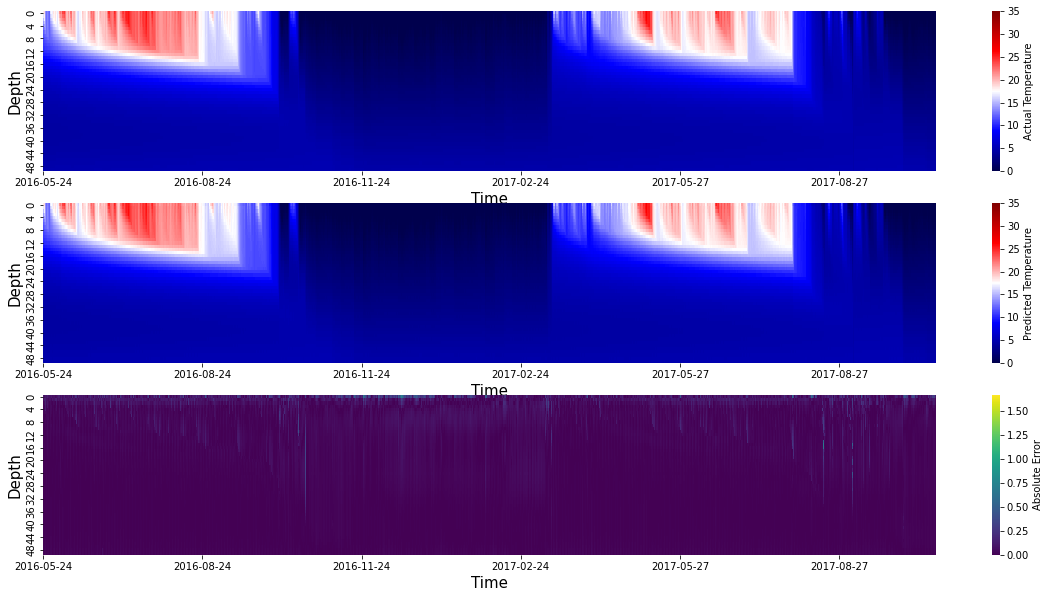

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

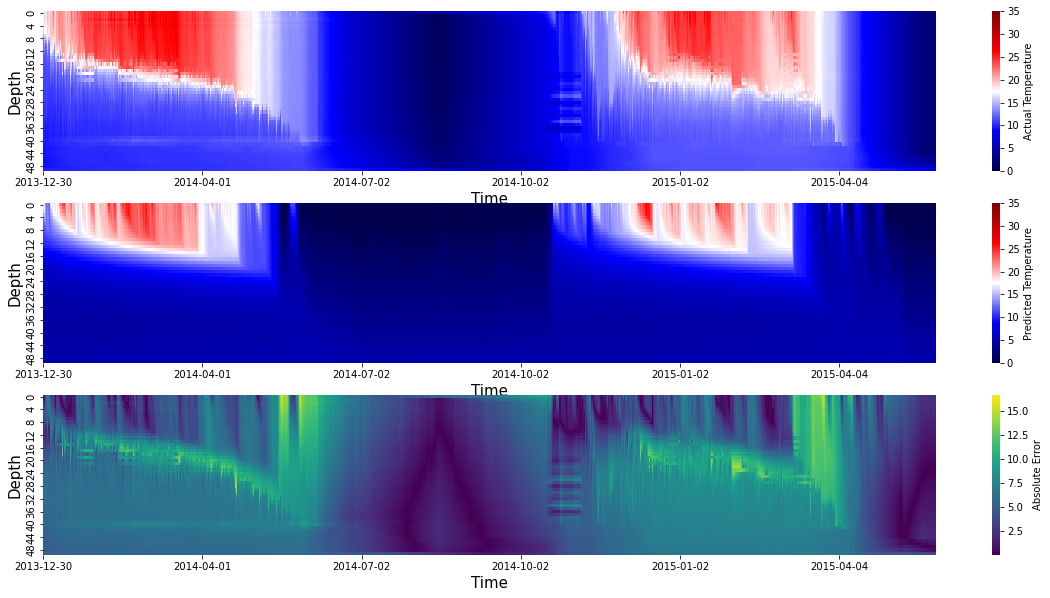

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.033281712095619365, Train L2 Error: 0.00442581153006798
Test RMSE: 0.03104979884448937, Train L2 Error: 0.0036995348293421817


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.020583315420999365, Train L2 Error: 0.0027374107471767714
Test RMSE: 0.023089614342098726, Train L2 Error: 0.0027513351801133723


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.025713488763726842, Train L2 Error: 0.0034197216556958177
Test RMSE: 0.024119336261043484, Train L2 Error: 0.0028740537896730584


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m1_pred = heat_diff_model(m1_input)
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:08<2:17:12,  8.24s/it]

Epoch : 0, Train_loss: 0.8668863199980569, Loss m0: 1.557572132817192e-06, Loss m1: 0.0038944031395858093,  Loss m3: 0.004035285036834656, Loss m4: 0.8668863199980569


  5%|▌         | 51/1000 [07:01<1:59:31,  7.56s/it]

Epoch : 50, Train_loss: 0.16659044587392424, Loss m0: 1.557572132817192e-06, Loss m1: 0.7179207292990936,  Loss m3: 0.7240103444495298, Loss m4: 0.16659044587392424


 10%|█         | 101/1000 [13:22<2:02:02,  8.15s/it]

Epoch : 100, Train_loss: 0.15410040099049402, Loss m0: 1.557572132817192e-06, Loss m1: 0.7413818928636186,  Loss m3: 0.7470607749122715, Loss m4: 0.15410040099049402


 15%|█▌        | 151/1000 [19:39<1:46:18,  7.51s/it]

Epoch : 150, Train_loss: 0.14701006682558665, Loss m0: 1.557572132817192e-06, Loss m1: 0.7494135580163718,  Loss m3: 0.7550187651599145, Loss m4: 0.14701006682558665


 20%|██        | 201/1000 [25:54<1:39:43,  7.49s/it]

Epoch : 200, Train_loss: 0.14053238838682652, Loss m0: 1.557572132817192e-06, Loss m1: 0.7551684282638642,  Loss m3: 0.7607513490086952, Loss m4: 0.14053238838682652


 25%|██▌       | 251/1000 [32:10<1:33:18,  7.47s/it]

Epoch : 250, Train_loss: 0.1337853966645114, Loss m0: 1.557572132817192e-06, Loss m1: 0.7604232923846564,  Loss m3: 0.7659861064753265, Loss m4: 0.1337853966645114


 30%|███       | 301/1000 [38:25<1:27:55,  7.55s/it]

Epoch : 300, Train_loss: 0.126139665966209, Loss m0: 1.557572132817192e-06, Loss m1: 0.7659388354097709,  Loss m3: 0.7714828552904861, Loss m4: 0.126139665966209


 35%|███▌      | 351/1000 [44:41<1:21:19,  7.52s/it]

Epoch : 350, Train_loss: 0.11700790379786892, Loss m0: 1.557572132817192e-06, Loss m1: 0.7721798601755058,  Loss m3: 0.7777200509641787, Loss m4: 0.11700790379786892


 40%|████      | 401/1000 [50:57<1:15:01,  7.51s/it]

Epoch : 400, Train_loss: 0.10634372784347121, Loss m0: 1.557572132817192e-06, Loss m1: 0.7793280187810102,  Loss m3: 0.7848864543630596, Loss m4: 0.10634372784347121


 45%|████▌     | 451/1000 [57:13<1:08:59,  7.54s/it]

Epoch : 450, Train_loss: 0.09583779483068179, Loss m0: 1.557572132817192e-06, Loss m1: 0.7884027935500777,  Loss m3: 0.793997593797715, Loss m4: 0.09583779483068179


 50%|█████     | 501/1000 [1:03:29<1:02:16,  7.49s/it]

Epoch : 500, Train_loss: 0.0880546991870705, Loss m0: 1.557572132817192e-06, Loss m1: 0.7990989188217477,  Loss m3: 0.8047369785355439, Loss m4: 0.0880546991870705


 55%|█████▌    | 551/1000 [1:09:42<55:40,  7.44s/it]  

Epoch : 550, Train_loss: 0.0833544579302244, Loss m0: 1.557572132817192e-06, Loss m1: 0.8083208227590322,  Loss m3: 0.8139905136400841, Loss m4: 0.0833544579302244


 60%|██████    | 601/1000 [1:15:53<49:20,  7.42s/it]

Epoch : 600, Train_loss: 0.08058486915666685, Loss m0: 1.557572132817192e-06, Loss m1: 0.8146033362545668,  Loss m3: 0.8202826274654513, Loss m4: 0.08058486915666685


 65%|██████▌   | 651/1000 [1:22:05<43:12,  7.43s/it]

Epoch : 650, Train_loss: 0.07879985959805591, Loss m0: 1.557572132817192e-06, Loss m1: 0.8184884404037643,  Loss m3: 0.8241633361209, Loss m4: 0.07879985959805591


 70%|███████   | 701/1000 [1:28:18<37:45,  7.58s/it]

Epoch : 700, Train_loss: 0.07752551664815181, Loss m0: 1.557572132817192e-06, Loss m1: 0.8209492686990748,  Loss m3: 0.8266155848088373, Loss m4: 0.07752551664815181


 75%|███████▌  | 751/1000 [1:34:33<31:17,  7.54s/it]

Epoch : 750, Train_loss: 0.07655149913670056, Loss m0: 1.557572132817192e-06, Loss m1: 0.8226289740558218,  Loss m3: 0.8282866911562479, Loss m4: 0.07655149913670056


 80%|████████  | 801/1000 [1:40:48<24:53,  7.50s/it]

Epoch : 800, Train_loss: 0.07577010904345396, Loss m0: 1.557572132817192e-06, Loss m1: 0.8238557206799663,  Loss m3: 0.8295057985839565, Loss m4: 0.07577010904345396


 85%|████████▌ | 851/1000 [1:47:03<18:37,  7.50s/it]

Epoch : 850, Train_loss: 0.07511771079586614, Loss m0: 1.557572132817192e-06, Loss m1: 0.8248005905365677,  Loss m3: 0.8304442378193027, Loss m4: 0.07511771079586614


 90%|█████████ | 901/1000 [1:53:18<12:21,  7.49s/it]

Epoch : 900, Train_loss: 0.07455482457374035, Loss m0: 1.557572132817192e-06, Loss m1: 0.8255579369886293,  Loss m3: 0.8311963299778025, Loss m4: 0.07455482457374035


 95%|█████████▌| 951/1000 [1:59:34<06:07,  7.50s/it]

Epoch : 950, Train_loss: 0.07405625058025096, Loss m0: 1.557572132817192e-06, Loss m1: 0.8261843666030597,  Loss m3: 0.8318185971203498, Loss m4: 0.07405625058025096


100%|██████████| 1000/1000 [2:05:42<00:00,  7.54s/it]


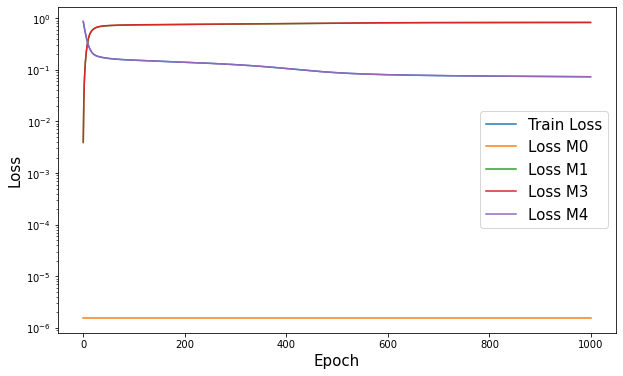

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.005698655
RMSE of after m1 1.109078
RMSE of after m3 1.1269891
RMSE of after m4 1.139482
RMSE of after m0 0.0065959557
RMSE of after m1 1.7115889
RMSE of after m3 1.7276114
RMSE of after m4 1.7402645
RMSE of after m0 0.0054394505
RMSE of after m1 1.7729989
RMSE of after m3 1.7774172
RMSE of after m4 1.7834805
RMSE of after m0 0.004059918
RMSE of after m1 1.7104235
RMSE of after m3 1.7078888
RMSE of after m4 1.7103347
RMSE of after m0 0.003050807
RMSE of after m1 1.6190131
RMSE of after m3 1.6165472
RMSE of after m4 1.638863
RMSE of after m0 0.002872178
RMSE of after m1 1.6001505
RMSE of after m3 1.5974156
RMSE of after m4 1.6204982
RMSE of after m0 0.0030956056
RMSE of after m1 1.5871178
RMSE of after m3 1.5853273
RMSE of after m4 1.603465
RMSE of after m0 0.0030653607
RMSE of after m1 1.5780559
RMSE of after m3 1.5763465
RMSE of after m4 1.5961373
RMSE of after m0 0.0026081062
RMSE of after m1 1.5457392
RMSE of after m3 1.5439101
RMSE of after m4 1.560994
RMSE of af

RMSE of after m3 1.0669346
RMSE of after m4 1.122599
RMSE of after m0 0.004292515
RMSE of after m1 1.1797985
RMSE of after m3 1.1788183
RMSE of after m4 1.2548738
RMSE of after m0 0.004045055
RMSE of after m1 1.2222024
RMSE of after m3 1.2207764
RMSE of after m4 1.3172555
RMSE of after m0 0.0035486782
RMSE of after m1 1.2439429
RMSE of after m3 1.2423265
RMSE of after m4 1.3453702
RMSE of after m0 0.004024436
RMSE of after m1 1.2967722
RMSE of after m3 1.2956591
RMSE of after m4 1.4157116
RMSE of after m0 0.0051343506
RMSE of after m1 1.3572168
RMSE of after m3 1.3566519
RMSE of after m4 1.4896607
RMSE of after m0 0.005408303
RMSE of after m1 1.3658811
RMSE of after m3 1.3651233
RMSE of after m4 1.5063565
RMSE of after m0 0.0053222035
RMSE of after m1 1.3551266
RMSE of after m3 1.3542145
RMSE of after m4 1.5013813
RMSE of after m0 0.004726663
RMSE of after m1 1.4076749
RMSE of after m3 1.4062567
RMSE of after m4 1.5418947
RMSE of after m0 0.0045920047
RMSE of after m1 1.472916
RMSE of 

RMSE of after m3 3.460908
RMSE of after m4 3.4728944
RMSE of after m0 0.005155025
RMSE of after m1 3.4827719
RMSE of after m3 3.5008736
RMSE of after m4 3.5120604
RMSE of after m0 0.004641602
RMSE of after m1 3.615105
RMSE of after m3 3.6347153
RMSE of after m4 3.6442714
RMSE of after m0 0.0044961306
RMSE of after m1 3.5638368
RMSE of after m3 3.5833833
RMSE of after m4 3.5934784
RMSE of after m0 0.0040538413
RMSE of after m1 3.5802717
RMSE of after m3 3.5995405
RMSE of after m4 3.609354
RMSE of after m0 0.011472831
RMSE of after m1 3.7339816
RMSE of after m3 3.752521
RMSE of after m4 3.7612581
RMSE of after m0 0.004718595
RMSE of after m1 3.563686
RMSE of after m3 3.5810301
RMSE of after m4 3.5914145
RMSE of after m0 0.0052247876
RMSE of after m1 3.6195543
RMSE of after m3 3.6375766
RMSE of after m4 3.6470218
RMSE of after m0 0.006612306
RMSE of after m1 3.726509
RMSE of after m3 3.7462363
RMSE of after m4 3.7546792
RMSE of after m0 0.006504935
RMSE of after m1 3.7712064
RMSE of after

RMSE of after m1 6.395392
RMSE of after m3 6.415209
RMSE of after m4 6.4138365
RMSE of after m0 0.006372942
RMSE of after m1 6.4872375
RMSE of after m3 6.5068717
RMSE of after m4 6.5063567
RMSE of after m0 0.0068154763
RMSE of after m1 6.446078
RMSE of after m3 6.4657483
RMSE of after m4 6.465118
RMSE of after m0 0.0064943344
RMSE of after m1 6.4767513
RMSE of after m3 6.495952
RMSE of after m4 6.4955873
RMSE of after m0 0.0063695465
RMSE of after m1 6.542562
RMSE of after m3 6.5616875
RMSE of after m4 6.561217
RMSE of after m0 0.0056545236
RMSE of after m1 6.553579
RMSE of after m3 6.573189
RMSE of after m4 6.572479
RMSE of after m0 0.0066098757
RMSE of after m1 6.4601946
RMSE of after m3 6.4797726
RMSE of after m4 6.4793983
RMSE of after m0 0.007811963
RMSE of after m1 6.4877443
RMSE of after m3 6.5080957
RMSE of after m4 6.507689
RMSE of after m0 0.007957545
RMSE of after m1 6.5021873
RMSE of after m3 6.52316
RMSE of after m4 6.5227666
RMSE of after m0 0.0056676706
RMSE of after m1 

RMSE of after m3 10.795052
RMSE of after m4 10.794149
RMSE of after m0 0.009810052
RMSE of after m1 9.424981
RMSE of after m3 9.453194
RMSE of after m4 9.449585
RMSE of after m0 0.005225222
RMSE of after m1 8.915741
RMSE of after m3 8.941747
RMSE of after m4 8.936003
RMSE of after m0 0.0047225617
RMSE of after m1 8.703667
RMSE of after m3 8.729911
RMSE of after m4 8.72387
RMSE of after m0 0.0045614983
RMSE of after m1 8.844871
RMSE of after m3 8.873735
RMSE of after m4 8.868714
RMSE of after m0 0.00482344
RMSE of after m1 9.096819
RMSE of after m3 9.127615
RMSE of after m4 9.124356
RMSE of after m0 0.005297882
RMSE of after m1 9.162327
RMSE of after m3 9.191807
RMSE of after m4 9.188394
RMSE of after m0 0.0060825385
RMSE of after m1 9.0635195
RMSE of after m3 9.091919
RMSE of after m4 9.088958
RMSE of after m0 0.0047834655
RMSE of after m1 9.623015
RMSE of after m3 9.649873
RMSE of after m4 9.648553
RMSE of after m0 0.00517826
RMSE of after m1 10.142172
RMSE of after m3 10.169375
RMSE 

RMSE of after m0 0.0069100657
RMSE of after m1 3.767551
RMSE of after m3 3.780419
RMSE of after m4 4.337577
RMSE of after m0 0.0059569385
RMSE of after m1 3.691667
RMSE of after m3 3.7038426
RMSE of after m4 4.245137
RMSE of after m0 0.0059305835
RMSE of after m1 3.632593
RMSE of after m3 3.6447704
RMSE of after m4 4.182077
RMSE of after m0 0.005991244
RMSE of after m1 3.3911479
RMSE of after m3 3.4023814
RMSE of after m4 3.9026344
RMSE of after m0 0.0052832705
RMSE of after m1 3.3259234
RMSE of after m3 3.3365867
RMSE of after m4 3.829786
RMSE of after m0 0.005998214
RMSE of after m1 3.2423377
RMSE of after m3 3.2533083
RMSE of after m4 3.748734
RMSE of after m0 0.006688093
RMSE of after m1 3.161543
RMSE of after m3 3.1731668
RMSE of after m4 3.6607049
RMSE of after m0 0.0063798563
RMSE of after m1 3.061095
RMSE of after m3 3.0727692
RMSE of after m4 3.5456905
RMSE of after m0 0.006826988
RMSE of after m1 2.9910784
RMSE of after m3 3.0034068
RMSE of after m4 3.4652884
RMSE of after m0

RMSE of after m1 1.1614842
RMSE of after m3 1.160335
RMSE of after m4 1.2554218
RMSE of after m0 0.004406388
RMSE of after m1 1.0690353
RMSE of after m3 1.0684267
RMSE of after m4 1.1548308
RMSE of after m0 0.0056142746
RMSE of after m1 1.1092577
RMSE of after m3 1.1088843
RMSE of after m4 1.2093112
RMSE of after m0 0.0050241207
RMSE of after m1 1.0619292
RMSE of after m3 1.0609112
RMSE of after m4 1.1567838
RMSE of after m0 0.0054830075
RMSE of after m1 1.0345685
RMSE of after m3 1.0330693
RMSE of after m4 1.1342256
RMSE of after m0 0.0061047166
RMSE of after m1 1.0387639
RMSE of after m3 1.0371994
RMSE of after m4 1.1436417
RMSE of after m0 0.006156276
RMSE of after m1 1.0365843
RMSE of after m3 1.0347682
RMSE of after m4 1.148856
RMSE of after m0 0.0060547693
RMSE of after m1 1.0535783
RMSE of after m3 1.0534115
RMSE of after m4 1.1806105
RMSE of after m0 0.006676292
RMSE of after m1 1.0548496
RMSE of after m3 1.0544952
RMSE of after m4 1.1826644
RMSE of after m0 0.007094202
RMSE of

RMSE of after m3 3.4502451
RMSE of after m4 3.4645758
RMSE of after m0 0.0071893753
RMSE of after m1 3.4806428
RMSE of after m3 3.4956496
RMSE of after m4 3.5097682
RMSE of after m0 0.00376243
RMSE of after m1 3.5896394
RMSE of after m3 3.6052587
RMSE of after m4 3.6184232
RMSE of after m0 0.0052581667
RMSE of after m1 3.6480248
RMSE of after m3 3.6630714
RMSE of after m4 3.675462
RMSE of after m0 0.0040278463
RMSE of after m1 3.6651232
RMSE of after m3 3.6794472
RMSE of after m4 3.6916623
RMSE of after m0 0.00512086
RMSE of after m1 3.748355
RMSE of after m3 3.765284
RMSE of after m4 3.7764196
RMSE of after m0 0.0053273067
RMSE of after m1 3.9160106
RMSE of after m3 3.933639
RMSE of after m4 3.9435923
RMSE of after m0 0.004799949
RMSE of after m1 4.011932
RMSE of after m3 4.029617
RMSE of after m4 4.0390334
RMSE of after m0 0.005281631
RMSE of after m1 4.189138
RMSE of after m3 4.2062206
RMSE of after m4 4.2142315
RMSE of after m0 0.006434452
RMSE of after m1 4.289713
RMSE of after m3

RMSE of after m4 6.7126336
RMSE of after m0 0.006198543
RMSE of after m1 6.5630345
RMSE of after m3 6.582854
RMSE of after m4 6.58226
RMSE of after m0 0.00569883
RMSE of after m1 6.5927825
RMSE of after m3 6.612527
RMSE of after m4 6.612143
RMSE of after m0 0.0056105386
RMSE of after m1 6.5978103
RMSE of after m3 6.6163445
RMSE of after m4 6.6163683
RMSE of after m0 0.0062275077
RMSE of after m1 6.594752
RMSE of after m3 6.613265
RMSE of after m4 6.6128764
RMSE of after m0 0.0070997425
RMSE of after m1 6.523383
RMSE of after m3 6.542362
RMSE of after m4 6.542201
RMSE of after m0 0.006730528
RMSE of after m1 6.543881
RMSE of after m3 6.5628815
RMSE of after m4 6.5632615
RMSE of after m0 0.008135108
RMSE of after m1 6.5688977
RMSE of after m3 6.587382
RMSE of after m4 6.5878367
RMSE of after m0 0.00933455
RMSE of after m1 6.613708
RMSE of after m3 6.6328106
RMSE of after m4 6.6329722
RMSE of after m0 0.008280272
RMSE of after m1 6.561371
RMSE of after m3 6.579918
RMSE of after m4 6.58053

RMSE of after m0 0.0055595557
RMSE of after m1 6.1802316
RMSE of after m3 6.1999288
RMSE of after m4 6.1950784
RMSE of after m0 0.009207372
RMSE of after m1 5.808403
RMSE of after m3 5.8351383
RMSE of after m4 5.8284087
RMSE of after m0 0.011791195
RMSE of after m1 6.118475
RMSE of after m3 6.152684
RMSE of after m4 6.144511
RMSE of after m0 0.0049186107
RMSE of after m1 6.5753236
RMSE of after m3 6.6116285
RMSE of after m4 6.6029673
RMSE of after m0 0.0039666826
RMSE of after m1 6.711004
RMSE of after m3 6.7449875
RMSE of after m4 6.7375746
RMSE of after m0 0.0037207662
RMSE of after m1 6.6670947
RMSE of after m3 6.6994333
RMSE of after m4 6.6927714
RMSE of after m0 0.0037536998
RMSE of after m1 6.689823
RMSE of after m3 6.7256794
RMSE of after m4 6.7174697
RMSE of after m0 0.0042269803
RMSE of after m1 6.6254764
RMSE of after m3 6.6596303
RMSE of after m4 6.6512523
RMSE of after m0 0.0047287843
RMSE of after m1 6.543484
RMSE of after m3 6.575969
RMSE of after m4 6.567354
RMSE of afte

RMSE of after m1 4.6506214
RMSE of after m3 4.6630316
RMSE of after m4 5.266128
RMSE of after m0 0.006764855
RMSE of after m1 4.5665307
RMSE of after m3 4.579309
RMSE of after m4 5.177158
RMSE of after m0 0.0073839175
RMSE of after m1 4.4856124
RMSE of after m3 4.498402
RMSE of after m4 5.0994024
RMSE of after m0 0.0062603005
RMSE of after m1 4.378413
RMSE of after m3 4.391379
RMSE of after m4 4.985735
RMSE of after m0 0.0065248986
RMSE of after m1 4.2969246
RMSE of after m3 4.309476
RMSE of after m4 4.902762
RMSE of after m0 0.00551092
RMSE of after m1 4.1830564
RMSE of after m3 4.1954274
RMSE of after m4 4.781772
RMSE of after m0 0.005651892
RMSE of after m1 4.1483097
RMSE of after m3 4.160365
RMSE of after m4 4.738881
RMSE of after m0 0.005437416
RMSE of after m1 4.093116
RMSE of after m3 4.105629
RMSE of after m4 4.6815634
RMSE of after m0 0.005472148
RMSE of after m1 3.9893105
RMSE of after m3 4.002291
RMSE of after m4 4.564912
RMSE of after m0 0.007948222
RMSE of after m1 3.97768

RMSE of after m0 0.008297481
RMSE of after m1 1.013674
RMSE of after m3 1.0125381
RMSE of after m4 1.0583421
RMSE of after m0 0.0067393603
RMSE of after m1 1.012425
RMSE of after m3 1.0106329
RMSE of after m4 1.0577605
RMSE of after m0 0.0053031133
RMSE of after m1 1.0049665
RMSE of after m3 1.0038836
RMSE of after m4 1.0516443
RMSE of after m0 0.005265263
RMSE of after m1 0.97306395
RMSE of after m3 0.9720845
RMSE of after m4 1.0215697
RMSE of after m0 0.0058272434
RMSE of after m1 0.94228625
RMSE of after m3 0.9412146
RMSE of after m4 0.9813278
RMSE of after m0 0.0059281695
RMSE of after m1 0.99457294
RMSE of after m3 0.993262
RMSE of after m4 1.0270022
RMSE of after m0 0.004866549
RMSE of after m1 1.0342981
RMSE of after m3 1.0327784
RMSE of after m4 1.078953
RMSE of after m0 0.0046466803
RMSE of after m1 1.0396225
RMSE of after m3 1.0377082
RMSE of after m4 1.0917197
RMSE of after m0 0.0056126625
RMSE of after m1 0.9383861
RMSE of after m3 0.9373905
RMSE of after m4 0.98872215
RMSE

RMSE of after m1 2.9255347
RMSE of after m3 2.9348366
RMSE of after m4 2.9503124
RMSE of after m0 0.007342848
RMSE of after m1 2.6369133
RMSE of after m3 2.6453927
RMSE of after m4 2.6634026
RMSE of after m0 0.0062064272
RMSE of after m1 2.7931473
RMSE of after m3 2.8022478
RMSE of after m4 2.8210962
RMSE of after m0 0.0049204156
RMSE of after m1 2.7582295
RMSE of after m3 2.7682538
RMSE of after m4 2.7866488
RMSE of after m0 0.0045394157
RMSE of after m1 2.8540826
RMSE of after m3 2.8653421
RMSE of after m4 2.8824139
RMSE of after m0 0.0043840013
RMSE of after m1 2.801601
RMSE of after m3 2.8131874
RMSE of after m4 2.8299217
RMSE of after m0 0.004771735
RMSE of after m1 2.7711945
RMSE of after m3 2.7830393
RMSE of after m4 2.8000746
RMSE of after m0 0.0062032547
RMSE of after m1 2.8473225
RMSE of after m3 2.858742
RMSE of after m4 2.876225
RMSE of after m0 0.004633751
RMSE of after m1 2.9579527
RMSE of after m3 2.9682655
RMSE of after m4 2.985786
RMSE of after m0 0.0046933116
RMSE of 

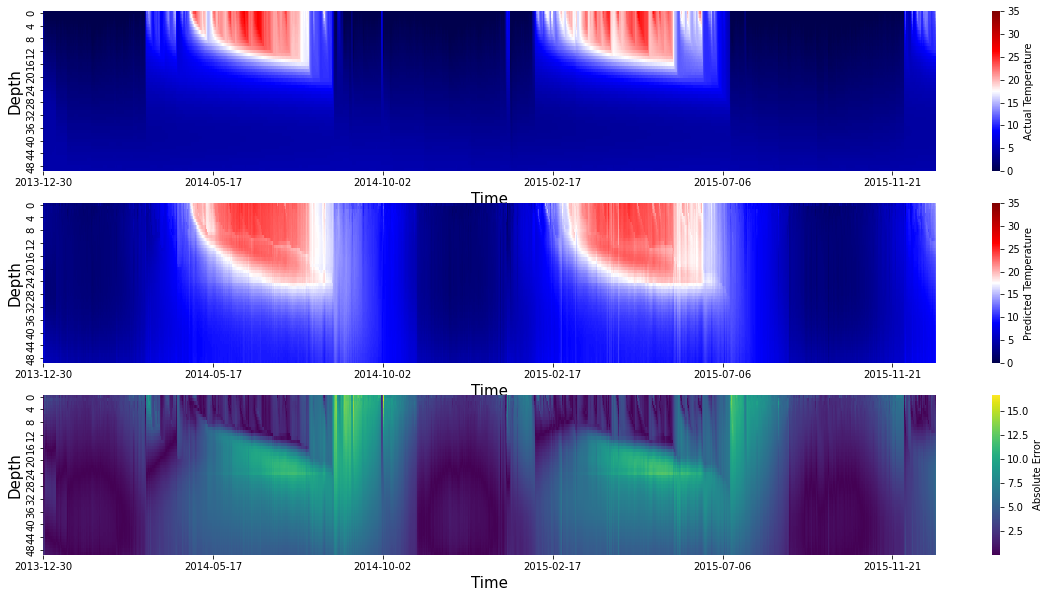

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

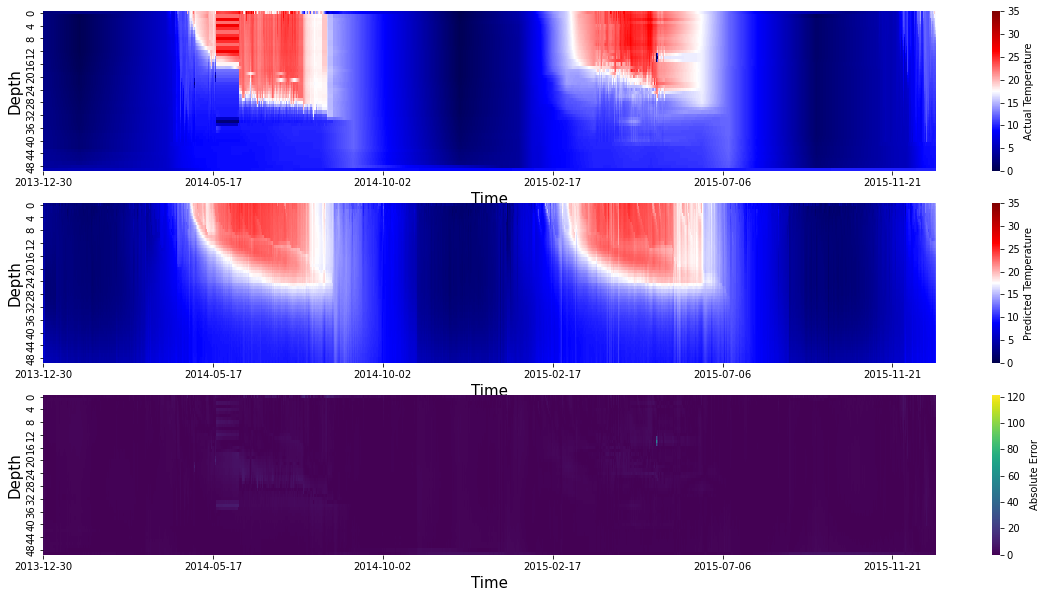

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.005462061
RMSE of after m1 4.0414777
RMSE of after m3 4.0592194
RMSE of after m4 4.066832
RMSE of after m0 0.008037725
RMSE of after m1 3.9587903
RMSE of after m3 3.977678
RMSE of after m4 3.9858916
RMSE of after m0 0.0050342428
RMSE of after m1 4.327982
RMSE of after m3 4.3479123
RMSE of after m4 4.351847
RMSE of after m0 0.004645544
RMSE of after m1 4.2962093
RMSE of after m3 4.315572
RMSE of after m4 4.3198504
RMSE of after m0 0.0034410742
RMSE of after m1 4.3915353
RMSE of after m3 4.410978
RMSE of after m4 4.4151683
RMSE of after m0 0.008830185
RMSE of after m1 4.503615
RMSE of after m3 4.5221915
RMSE of after m4 4.524867
RMSE of after m0 0.0040880223
RMSE of after m1 4.3827276
RMSE of after m3 4.4007983
RMSE of after m4 4.4047346
RMSE of after m0 0.004208882
RMSE of after m1 4.380281
RMSE of after m3 4.3992934
RMSE of after m4 4.402511
RMSE of after m0 0.004043874
RMSE of after m1 4.4074254
RMSE of after m3 4.4267774
RMSE of after m4 4.4299846
RMSE of after m0 

RMSE of after m1 6.662175
RMSE of after m3 6.6840935
RMSE of after m4 6.6822786
RMSE of after m0 0.006880863
RMSE of after m1 6.8487935
RMSE of after m3 6.8715773
RMSE of after m4 6.869751
RMSE of after m0 0.005832013
RMSE of after m1 6.81485
RMSE of after m3 6.8369603
RMSE of after m4 6.835789
RMSE of after m0 0.005290721
RMSE of after m1 6.7793045
RMSE of after m3 6.801513
RMSE of after m4 6.80069
RMSE of after m0 0.0051919715
RMSE of after m1 6.753321
RMSE of after m3 6.7746377
RMSE of after m4 6.7741265
RMSE of after m0 0.0056039914
RMSE of after m1 6.7352686
RMSE of after m3 6.755961
RMSE of after m4 6.755057
RMSE of after m0 0.007614554
RMSE of after m1 6.687648
RMSE of after m3 6.7090063
RMSE of after m4 6.707686
RMSE of after m0 0.008135642
RMSE of after m1 6.689913
RMSE of after m3 6.7122407
RMSE of after m4 6.711066
RMSE of after m0 0.005916123
RMSE of after m1 6.730015
RMSE of after m3 6.752247
RMSE of after m4 6.751552
RMSE of after m0 0.0056797117
RMSE of after m1 6.75548


RMSE of after m1 5.8961825
RMSE of after m3 5.9303513
RMSE of after m4 5.92124
RMSE of after m0 0.004579877
RMSE of after m1 5.9274416
RMSE of after m3 5.9621234
RMSE of after m4 5.9537916
RMSE of after m0 0.004114919
RMSE of after m1 5.8880286
RMSE of after m3 5.92113
RMSE of after m4 5.91315
RMSE of after m0 0.0039641084
RMSE of after m1 5.8598914
RMSE of after m3 5.8943863
RMSE of after m4 5.8856735
RMSE of after m0 0.0054285773
RMSE of after m1 5.875797
RMSE of after m3 5.9113235
RMSE of after m4 5.901812
RMSE of after m0 0.0037872517
RMSE of after m1 5.980491
RMSE of after m3 6.015296
RMSE of after m4 6.006727
RMSE of after m0 0.0068252003
RMSE of after m1 5.978888
RMSE of after m3 6.0165486
RMSE of after m4 6.008601
RMSE of after m0 0.00567252
RMSE of after m1 6.0624037
RMSE of after m3 6.0981407
RMSE of after m4 6.09124
RMSE of after m0 0.005872125
RMSE of after m1 6.296036
RMSE of after m3 6.330127
RMSE of after m4 6.322695
RMSE of after m0 0.004980443
RMSE of after m1 6.519209

RMSE of after m1 3.7483034
RMSE of after m3 3.75833
RMSE of after m4 4.2193
RMSE of after m0 0.005191416
RMSE of after m1 3.6950517
RMSE of after m3 3.7052708
RMSE of after m4 4.157217
RMSE of after m0 0.0060461927
RMSE of after m1 3.5545146
RMSE of after m3 3.565767
RMSE of after m4 4.0420933
RMSE of after m0 0.0065499316
RMSE of after m1 3.413499
RMSE of after m3 3.4252398
RMSE of after m4 3.8783329
RMSE of after m0 0.005159009
RMSE of after m1 3.270631
RMSE of after m3 3.2818682
RMSE of after m4 3.6938586
RMSE of after m0 0.004931334
RMSE of after m1 3.228046
RMSE of after m3 3.2385426
RMSE of after m4 3.652526
RMSE of after m0 0.0056160507
RMSE of after m1 3.1864011
RMSE of after m3 3.1964638
RMSE of after m4 3.6186492
RMSE of after m0 0.005347948
RMSE of after m1 3.0455105
RMSE of after m3 3.0557723
RMSE of after m4 3.441727
RMSE of after m0 0.0071312906
RMSE of after m1 3.0481768
RMSE of after m3 3.0570393
RMSE of after m4 3.4277096
RMSE of after m0 0.005535313
RMSE of after m1 2

RMSE of after m3 0.9896656
RMSE of after m4 1.0864465
RMSE of after m0 0.0056260917
RMSE of after m1 0.9310335
RMSE of after m3 0.9293083
RMSE of after m4 1.0378073
RMSE of after m0 0.0057234704
RMSE of after m1 0.9367187
RMSE of after m3 0.9352155
RMSE of after m4 1.0474712
RMSE of after m0 0.0061867535
RMSE of after m1 0.9537739
RMSE of after m3 0.9530093
RMSE of after m4 1.0698097
RMSE of after m0 0.0064404863
RMSE of after m1 0.9649659
RMSE of after m3 0.96414
RMSE of after m4 1.083104
RMSE of after m0 0.005829582
RMSE of after m1 1.0122144
RMSE of after m3 1.0110539
RMSE of after m4 1.1270844
RMSE of after m0 0.005589705
RMSE of after m1 1.0013257
RMSE of after m3 0.99993277
RMSE of after m4 1.1195275
RMSE of after m0 0.006884662
RMSE of after m1 1.0320212
RMSE of after m3 1.0308105
RMSE of after m4 1.1558753
RMSE of after m0 0.007816866
RMSE of after m1 1.1157539
RMSE of after m3 1.1149724
RMSE of after m4 1.185905
RMSE of after m0 0.0049391612
RMSE of after m1 1.2639728
RMSE of 

RMSE of after m0 0.0066296384
RMSE of after m1 3.452639
RMSE of after m3 3.469944
RMSE of after m4 3.4827976
RMSE of after m0 0.0051222933
RMSE of after m1 3.495303
RMSE of after m3 3.5131512
RMSE of after m4 3.5255604
RMSE of after m0 0.0039030141
RMSE of after m1 3.5596316
RMSE of after m3 3.577591
RMSE of after m4 3.58934
RMSE of after m0 0.008483924
RMSE of after m1 3.5209293
RMSE of after m3 3.5373378
RMSE of after m4 3.5488157
RMSE of after m0 0.0060593565
RMSE of after m1 3.558509
RMSE of after m3 3.5740817
RMSE of after m4 3.5853543
RMSE of after m0 0.004676813
RMSE of after m1 3.3704386
RMSE of after m3 3.3873198
RMSE of after m4 3.3990457
RMSE of after m0 0.00393101
RMSE of after m1 3.3873334
RMSE of after m3 3.404573
RMSE of after m4 3.4163337
RMSE of after m0 0.0041177794
RMSE of after m1 3.4392054
RMSE of after m3 3.456531
RMSE of after m4 3.4677296
RMSE of after m0 0.0045852195
RMSE of after m1 3.4921842
RMSE of after m3 3.508865
RMSE of after m4 3.5195432
RMSE of after m

RMSE of after m3 6.9662333
RMSE of after m4 6.9617634
RMSE of after m0 0.0052829967
RMSE of after m1 6.9876184
RMSE of after m3 7.0115457
RMSE of after m4 7.007213
RMSE of after m0 0.0058194315
RMSE of after m1 6.943319
RMSE of after m3 6.9676256
RMSE of after m4 6.963834
RMSE of after m0 0.007460313
RMSE of after m1 6.996635
RMSE of after m3 7.0219345
RMSE of after m4 7.0181746
RMSE of after m0 0.0046557714
RMSE of after m1 7.140142
RMSE of after m3 7.1649632
RMSE of after m4 7.161384
RMSE of after m0 0.006184029
RMSE of after m1 7.2207127
RMSE of after m3 7.2447367
RMSE of after m4 7.2416115
RMSE of after m0 0.0049621603
RMSE of after m1 7.0939054
RMSE of after m3 7.1173306
RMSE of after m4 7.113796
RMSE of after m0 0.0065234923
RMSE of after m1 7.0563097
RMSE of after m3 7.080722
RMSE of after m4 7.0770526
RMSE of after m0 0.00533552
RMSE of after m1 7.1264462
RMSE of after m3 7.1513405
RMSE of after m4 7.1481385
RMSE of after m0 0.0048492434
RMSE of after m1 7.172401
RMSE of after 

RMSE of after m1 8.486825
RMSE of after m3 8.522598
RMSE of after m4 8.518888
RMSE of after m0 0.004659337
RMSE of after m1 8.528772
RMSE of after m3 8.562502
RMSE of after m4 8.559189
RMSE of after m0 0.0045618475
RMSE of after m1 8.520692
RMSE of after m3 8.553014
RMSE of after m4 8.549457
RMSE of after m0 0.0045571853
RMSE of after m1 8.472658
RMSE of after m3 8.504146
RMSE of after m4 8.500571
RMSE of after m0 0.0044432413
RMSE of after m1 8.507684
RMSE of after m3 8.53883
RMSE of after m4 8.536455
RMSE of after m0 0.004964594
RMSE of after m1 8.798551
RMSE of after m3 8.82926
RMSE of after m4 8.828166
RMSE of after m0 0.0064533185
RMSE of after m1 9.04374
RMSE of after m3 9.076877
RMSE of after m4 9.07542
RMSE of after m0 0.0072049014
RMSE of after m1 9.0461445
RMSE of after m3 9.076982
RMSE of after m4 9.075156
RMSE of after m0 0.005776459
RMSE of after m1 8.604549
RMSE of after m3 8.632549
RMSE of after m4 8.628176
RMSE of after m0 0.0063089207
RMSE of after m1 8.353103
RMSE of 

RMSE of after m1 3.911742
RMSE of after m3 3.923978
RMSE of after m4 4.3365946
RMSE of after m0 0.004972424
RMSE of after m1 3.8496425
RMSE of after m3 3.8619115
RMSE of after m4 4.268067
RMSE of after m0 0.0052540875
RMSE of after m1 3.8458579
RMSE of after m3 3.858782
RMSE of after m4 4.294051
RMSE of after m0 0.006114233
RMSE of after m1 3.7802107
RMSE of after m3 3.7925255
RMSE of after m4 4.260458
RMSE of after m0 0.006928633
RMSE of after m1 3.650107
RMSE of after m3 3.6610706
RMSE of after m4 4.0956435
RMSE of after m0 0.006246847
RMSE of after m1 3.4621096
RMSE of after m3 3.4725878
RMSE of after m4 3.871721
RMSE of after m0 0.0062154173
RMSE of after m1 3.3351512
RMSE of after m3 3.3459954
RMSE of after m4 3.7333934
RMSE of after m0 0.00613577
RMSE of after m1 3.2836428
RMSE of after m3 3.295052
RMSE of after m4 3.6625156
RMSE of after m0 0.0074630305
RMSE of after m1 3.2332003
RMSE of after m3 3.2430513
RMSE of after m4 3.601161
RMSE of after m0 0.006658398
RMSE of after m1 3

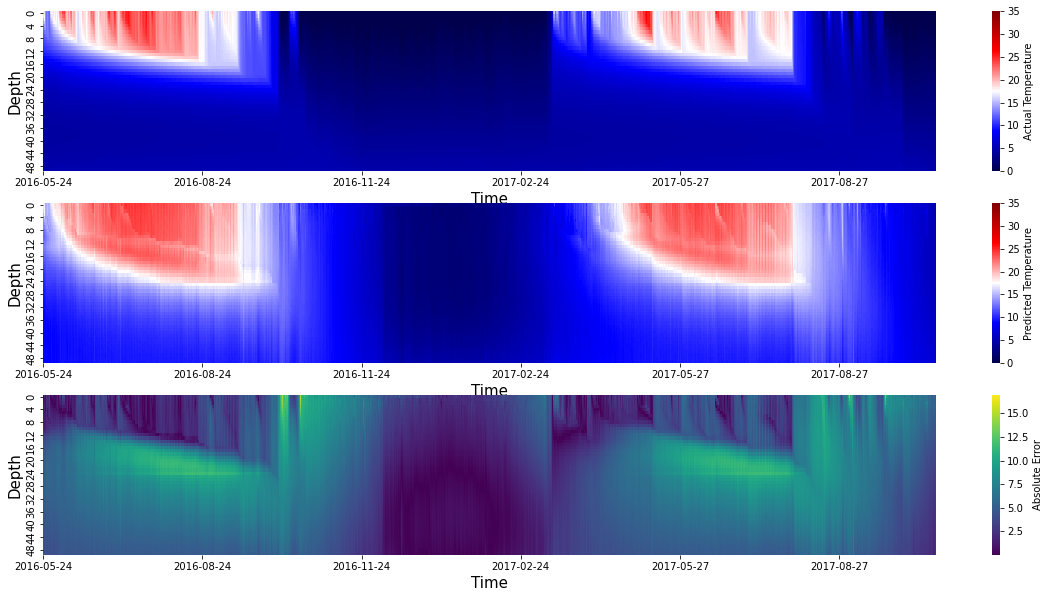

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

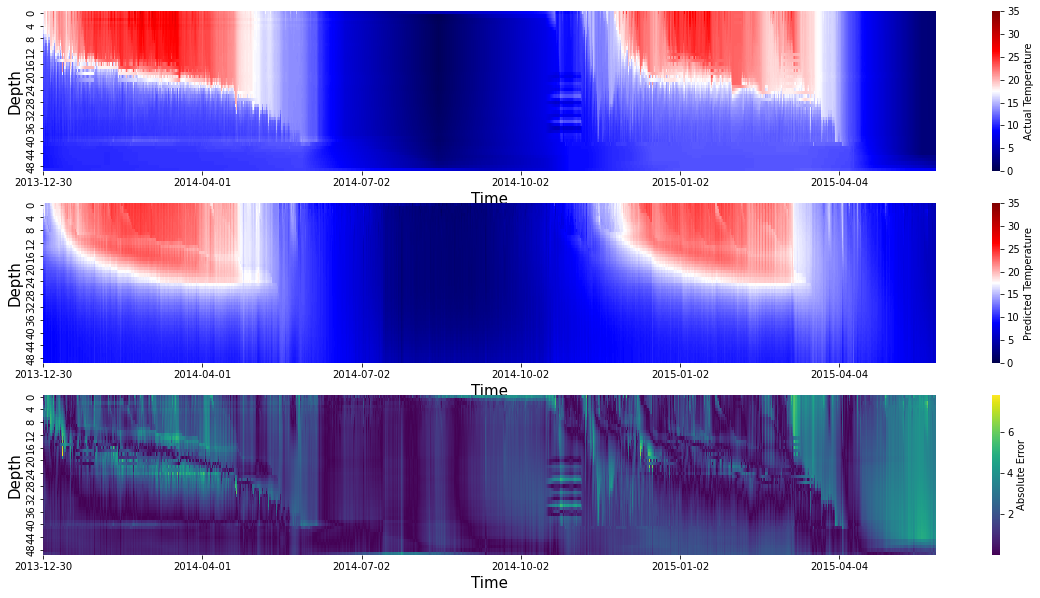

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.800484374494354, Train L2 Error: 0.638369775975099
Test RMSE: 5.5371608758380155, Train L2 Error: 0.6597440330750871


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.020583315420999365, Train L2 Error: 0.0027374107471767714
Test RMSE: 0.023089614342098726, Train L2 Error: 0.0027513351801133723


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.025713488763726842, Train L2 Error: 0.0034197216556958177
Test RMSE: 0.024119336261043484, Train L2 Error: 0.0028740537896730584


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8384014368057251
L2 Norm: 5.903360366821289


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities